<a href="https://colab.research.google.com/github/Kishore-Vijayakumar/Dataset_1/blob/main/PlantVillage_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/PlantVillage"
img_size = (128, 128)
batch_size = 16

SEED = 42

In [ ]:
# Parameters
images_per_class = 40


In [ ]:
# ✅ Install dependencies
!pip install tensorflow scikit-learn scikit-plot --quiet

In [ ]:
# ✅ Imports


import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns, time
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd


In [ ]:
# Gather random samples
all_images, all_labels = [], []
for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(cls_path):
        continue

    images = [os.path.join(cls_path, f) for f in os.listdir(cls_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(images) == 0:
        continue

    # Randomly pick up to 40 images
    selected = random.sample(images, min(len(images), images_per_class))
    all_images.extend(selected)
    all_labels.extend([cls] * len(selected))

print(f"✅ Selected {len(all_images)} total images across {len(set(all_labels))} classes.")

✅ Selected 1560 total images across 39 classes.


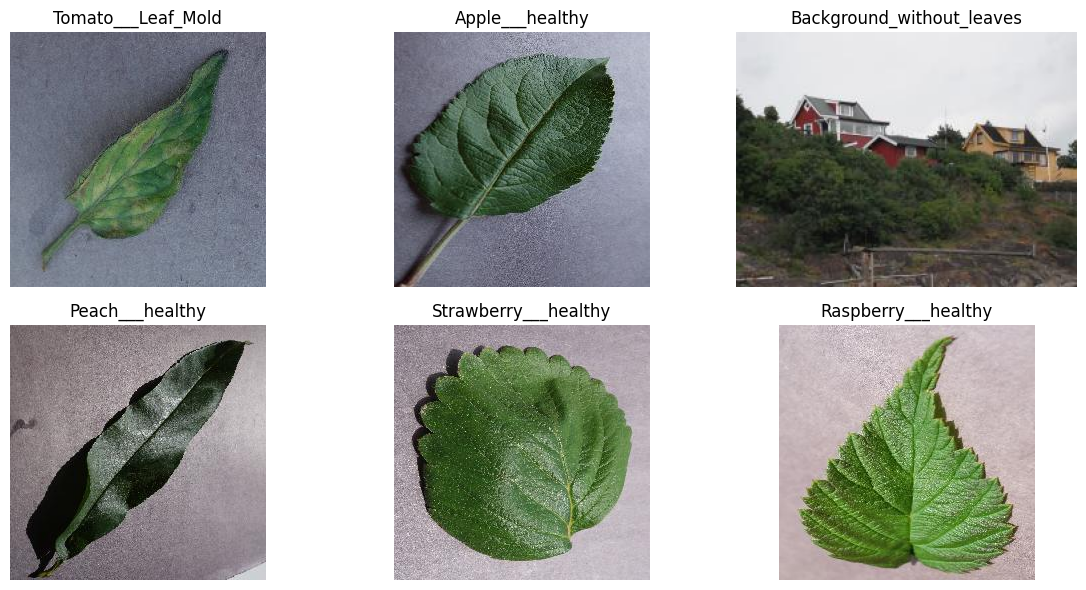

In [ ]:
# ✅ Number of samples to display
num_samples = 6

# Randomly pick images to visualize
sample_indices = random.sample(range(len(all_images)), min(num_samples, len(all_images)))

plt.figure(figsize=(12, 6))
for i, idx in enumerate(sample_indices):
    img_path = all_images[idx]
    label = all_labels[idx]
    img = plt.imread(img_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Create dataframe
df = pd.DataFrame({
    'filename': all_images,
    'class': all_labels
})

In [ ]:
df.head()

,filename,class
0,/content/drive/MyDrive/PlantVillage/Apple___Ap...,Apple___Apple_scab
1,/content/drive/MyDrive/PlantVillage/Apple___Ap...,Apple___Apple_scab
2,/content/drive/MyDrive/PlantVillage/Apple___Ap...,Apple___Apple_scab
3,/content/drive/MyDrive/PlantVillage/Apple___Ap...,Apple___Apple_scab
4,/content/drive/MyDrive/PlantVillage/Apple___Ap...,Apple___Apple_scab


In [ ]:
df['class'].head()

,class
0,Apple___Apple_scab
1,Apple___Apple_scab
2,Apple___Apple_scab
3,Apple___Apple_scab
4,Apple___Apple_scab


In [ ]:
df['class'].nunique()

39

In [ ]:
df['filename'].head()

,filename
0,/content/drive/MyDrive/PlantVillage/Apple___Ap...
1,/content/drive/MyDrive/PlantVillage/Apple___Ap...
2,/content/drive/MyDrive/PlantVillage/Apple___Ap...
3,/content/drive/MyDrive/PlantVillage/Apple___Ap...
4,/content/drive/MyDrive/PlantVillage/Apple___Ap...


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'filename' and 'class' are your columns
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['class'] # This ensures proportional representation
)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,

)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(128,128),
    batch_size=32,
    shuffle=True,            # Shuffle during training
    class_mode='categorical'
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(128,128),
    batch_size=32,
    shuffle=False,           # ✅ DO NOT shuffle during validation/testing
    class_mode='categorical'
)


Found 1248 validated image filenames belonging to 39 classes.
Found 312 validated image filenames belonging to 39 classes.


In [ ]:
len(train_gen.class_indices)

39

In [ ]:
print("🔹 Number of training classes:", len(train_gen.class_indices))
print("🔹 Number of validation classes:", len(val_gen.class_indices))

print("\nClass mapping (label → index):")
print(train_gen.class_indices)

🔹 Number of training classes: 39
🔹 Number of validation classes: 39

Class mapping (label → index):
{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Background_without_leaves': 4, 'Blueberry___healthy': 5, 'Cherry___Powdery_mildew': 6, 'Cherry___healthy': 7, 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 8, 'Corn___Common_rust': 9, 'Corn___Northern_Leaf_Blight': 10, 'Corn___healthy': 11, 'Grape___Black_rot': 12, 'Grape___Esca_(Black_Measles)': 13, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14, 'Grape___healthy': 15, 'Orange___Haunglongbing_(Citrus_greening)': 16, 'Peach___Bacterial_spot': 17, 'Peach___healthy': 18, 'Pepper,_bell___Bacterial_spot': 19, 'Pepper,_bell___healthy': 20, 'Potato___Early_blight': 21, 'Potato___Late_blight': 22, 'Potato___healthy': 23, 'Raspberry___healthy': 24, 'Soybean___healthy': 25, 'Squash___Powdery_mildew': 26, 'Strawberry___Leaf_scorch': 27, 'Strawberry___healthy': 28, 'Tomato___Bacterial_spot': 29

In [ ]:

# CNN Model (Functional API + MobileNetV2)
# ==========================================
base_model = MobileNetV2(input_shape=(128,128,3), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = Input(shape=(128,128,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
num_classes = len(train_gen.class_indices)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

#  Training CNN
# ==========================================
early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

start_time = time.time()
history = model.fit(
    train_gen,
    epochs=3,
    validation_data=val_gen,
    callbacks=[early_stop],
    verbose=1
)
train_time = time.time() - start_time


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
39/39 ━━━━━━━━━━━━━━━━━━━━ 498s 13s/step - accuracy: 0.1115 - loss: 3.5395 - val_accuracy: 0.5481 - val_loss: 2.0004
Epoch 2/3
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 603ms/step - accuracy: 0.5193 - loss: 1.7711 - val_accuracy: 0.7115 - val_loss: 1.1912
Epoch 3/3
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 577ms/step - accuracy: 0.7068 - loss: 1.0644 - val_accuracy: 0.7468 - val_loss: 0.9210


In [ ]:
print("Training samples:", train_gen.samples)
print("Validation samples:", val_gen.samples)


Training samples: 1248
Validation samples: 312


In [ ]:
results = []
algorithms_preds = {}

In [ ]:
algorithms_preds = {}   # store predictions
algorithms_metrics = [] # store metrics

In [ ]:

#  Evaluate CNN
# ==========================================
val_gen.reset()
preds = model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
algorithms_preds['CNN'] = y_pred

cnn_acc = accuracy_score(y_true, y_pred)
cnn_f1 = f1_score(y_true, y_pred, average='macro')
cnn_prec = precision_score(y_true, y_pred, average='macro')
cnn_rec = recall_score(y_true, y_pred, average='macro')

algorithms_metrics.append({
    "Algorithm": "CNN",
    "Accuracy": cnn_acc,
    "Precision": cnn_prec,
    "Recall": cnn_rec,
    "F1": cnn_f1,
    "TrainTime": train_time/60
})

print("\n CNN Metrics:")
print(f"Accuracy: {cnn_acc:.4f}, Precision: {cnn_prec:.4f}, Recall: {cnn_rec:.4f}, F1: {cnn_f1:.4f}, Training Time: {train_time/60:.2f} mins")




10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 585ms/step

 CNN Metrics:
Accuracy: 0.7468, Precision: 0.7786, Recall: 0.7468, F1: 0.7443, Training Time: 9.46 mins


In [ ]:
# ==========================================
# Feature Extraction from trained CNN
# ==========================================
print("\n🔍 Extracting CNN features for classical ML...")

# Use the output of the GlobalAveragePooling layer (one before Dense)
feature_extractor = Model(inputs=model.input, outputs=model.layers[-4].output)

X_train = feature_extractor.predict(train_gen, verbose=1)
X_val = feature_extractor.predict(val_gen, verbose=1)
y_train = train_gen.classes
y_val = val_gen.classes


🔍 Extracting CNN features for classical ML...
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 507ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 538ms/step


In [ ]:
print(f" Feature shapes: X_train={X_train.shape}, X_val={X_val.shape}")

In [ ]:
# ==========================================
# 2️⃣ Feature Normalization & PCA
# ==========================================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("\n⚙️ Scaling + PCA reduction...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Reduce dimensions to 100 principal components
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)


⚙️ Scaling + PCA reduction...


In [ ]:
# ==========================================
# 3️⃣ Classical ML Models
# ==========================================
models_list = {
    "SVM": SVC(kernel='rbf', gamma='scale', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

In [ ]:
print("\n🚀 Training classical ML models...")
for name, clf in models_list.items():
    print(f"\n🔹 Training {name}...")
    start_time = time.time()
    clf.fit(X_train_pca, y_train)
    train_time = time.time() - start_time

    y_pred = clf.predict(X_val_pca)
    algorithms_preds[name] = y_pred

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro', zero_division=0)

    results.append({
        "Algorithm": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "TrainTime": train_time
    })


🚀 Training classical ML models...

🔹 Training SVM...

🔹 Training Random Forest...

🔹 Training KNN...


In [ ]:
# ==========================================
# 4️⃣ Combine with CNN metrics
# ==========================================
results.append({
    "Algorithm": "CNN",
    "Accuracy": cnn_acc,
    "Precision": cnn_prec,
    "Recall": cnn_rec,
    "F1": cnn_f1,
    "TrainTime": train_time/60
})

In [ ]:
df_results = pd.DataFrame(results)
print("\n--- 📊 Final Results (Improved) ---")
print(df_results)


--- 📊 Final Results (Improved) ---
       Algorithm  Accuracy  Precision    Recall        F1  TrainTime
0            SVM  0.048077   0.044681  0.048077  0.039166   0.251459
1  Random Forest  0.035256   0.036289  0.035256  0.032683   4.443872
2            KNN  0.035256   0.035618  0.035256  0.020492   0.001442
3            CNN  0.746795   0.778625  0.746795  0.744335   0.000024


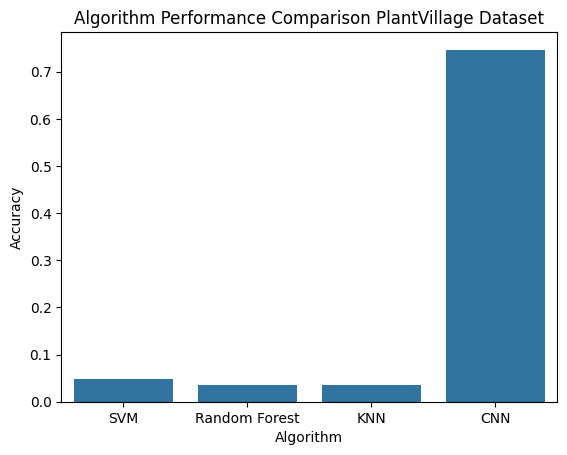

In [ ]:
# Plot comparison
sns.barplot(x="Algorithm", y="Accuracy", data=df_results)
plt.title("Algorithm Performance Comparison PlantVillage Dataset")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score


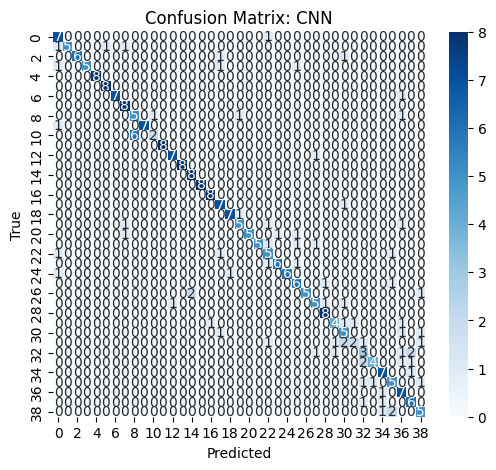

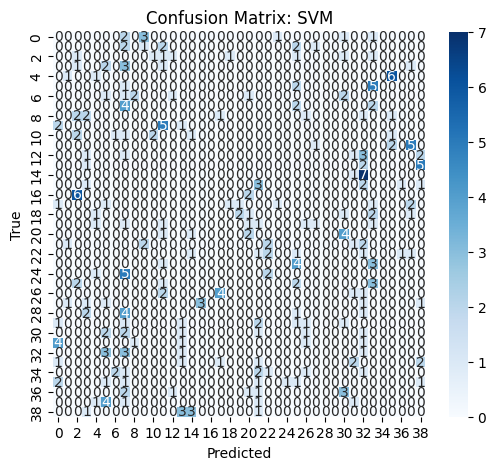

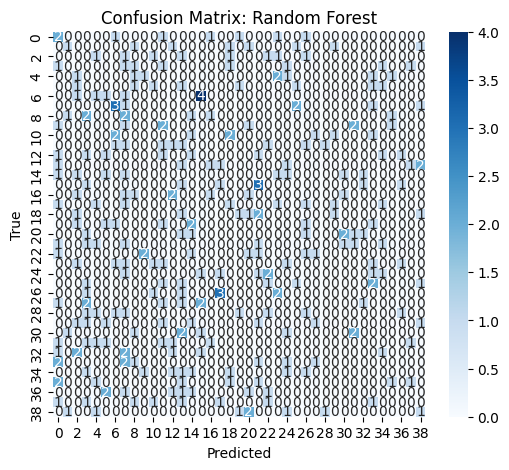

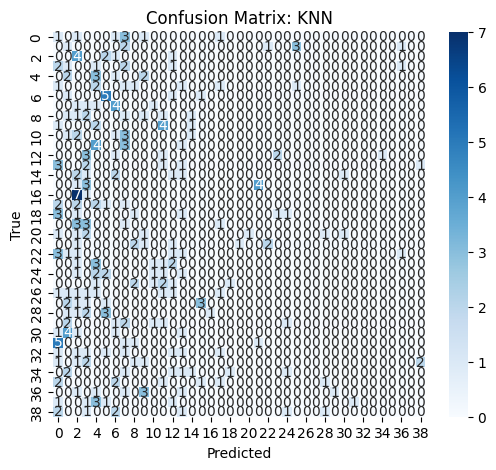

In [ ]:
# Confusion Matrices
# ------------------------------------------------
for algo, preds in algorithms_preds.items():
    cm = confusion_matrix(y_val, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {algo}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

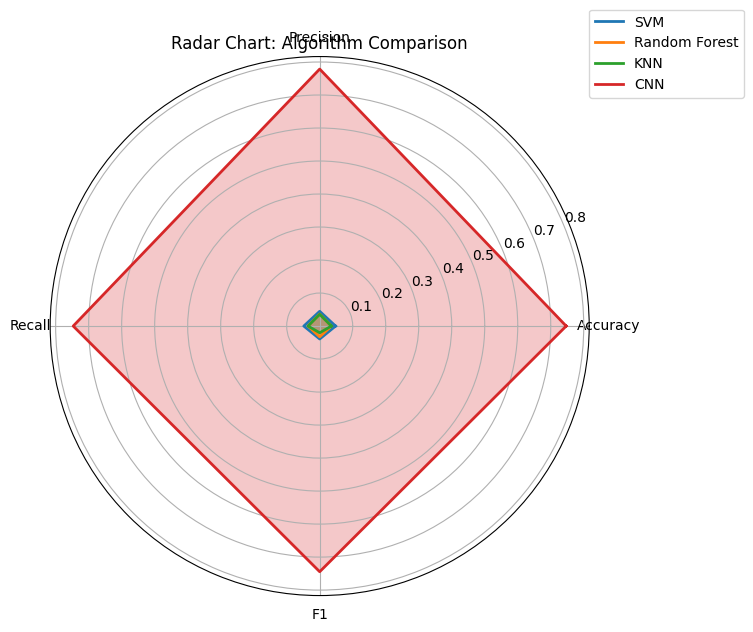

In [ ]:
 #Radar Chart (Accuracy, Precision, Recall, F1)
# ------------------------------------------------
from math import pi
categories = ['Accuracy','Precision','Recall','F1']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

for i, row in df_results.iterrows():
    values = [row[cat] for cat in categories]
    values += values[:1]  # complete loop
    ax.plot(angles, values, linewidth=2, label=row['Algorithm'])
    ax.fill(angles, values, alpha=0.25)

plt.xticks(angles[:-1], categories)
plt.title("Radar Chart: Algorithm Comparison")
plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.1))
plt.show()

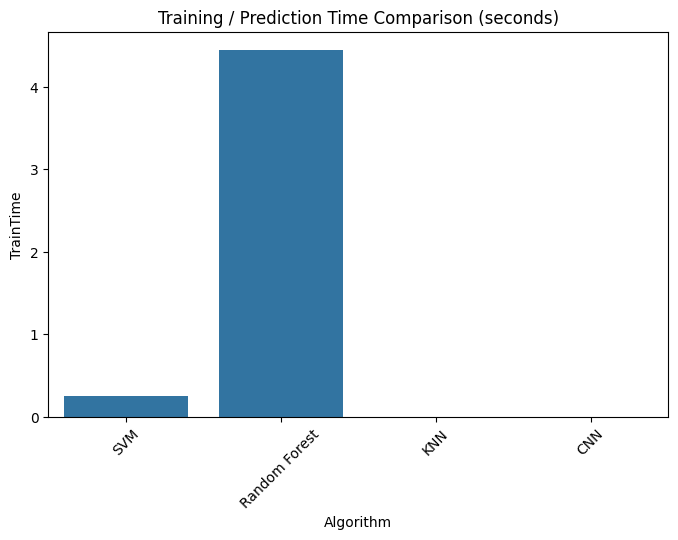

In [ ]:
# 6️⃣ Training Time Bar
# ------------------------------------------------
plt.figure(figsize=(8,5))
sns.barplot(x='Algorithm', y='TrainTime', data=df_results)
plt.title("Training / Prediction Time Comparison (seconds)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# ---------------------------------------------
# Prepare labels for ROC (one-hot encoding)
# ---------------------------------------------
# Get all class labels
y_val = val_gen.classes

n_classes = len(np.unique(y_val))
y_val_bin = label_binarize(y_val, classes=range(n_classes))

plt.figure(figsize=(12,8))


<Figure size 1200x800 with 0 Axes>

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 337ms/step


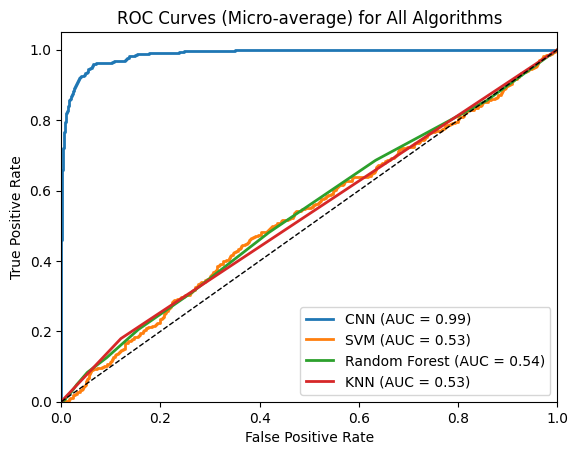

In [ ]:
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'])
algorithm_list = ["CNN", "SVM", "Random Forest", "KNN"]

for algo in algorithm_list:
    y_score = algorithms_preds[algo]

    # For CNN, preds are probabilities
    if algo == "CNN":
        y_score = model.predict(val_gen)

    # For classical ML, need probability estimates
    else:
        if hasattr(models_list[algo], "predict_proba"):
            y_score = models_list[algo].predict_proba(X_val)
        else:
            # Decision function as probability substitute for SVM
            y_score = models_list[algo].decision_function(X_val)
            # If binary, reshape
            if n_classes == 2 and y_score.ndim == 1:
                y_score = np.vstack([1 - y_score, y_score]).T

    # Compute ROC and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr["micro"], tpr["micro"], label=f'{algo} (AUC = {roc_auc["micro"]:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Micro-average) for All Algorithms')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the evaluation metrics to CSV
df_results.to_csv("plant_village_evaluation_metrics.csv", index=False)
print(" Evaluation metrics saved as 'evaluation_metrics.csv'")

 Evaluation metrics saved as 'evaluation_metrics.csv'


In [ ]:
# Save entire model in HDF5 format
model.save("cnn_plant_disease_model.h5")
print("✅ CNN model saved as 'cnn_plant_disease_model.h5'")


✅ CNN model saved as 'cnn_plant_disease_model.h5'
